In [ ]:
#| default_exp feature

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import torch
import cv2
import numpy as np
import kornia

from kornia.utils import tensor_to_image, image_to_tensor
from typing import List, Union, Tuple, Optional
from copy import deepcopy

import matplotlib.pyplot as plt
import torch.nn as nn
from torch import allclose
from typing import Union

from kornia_moons.viz import visualize_LAF, draw_LAF_matches

In [ ]:
#| export 


def to_numpy_image(img: Union[str, np.array, torch.Tensor]):
    if type(img) is str:
        img_out = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    elif isinstance(img, torch.Tensor):
        img_out = tensor_to_image(img)
    elif isinstance(img, np.ndarray):
        img_out = img
    else:
        raise TypeError('img should be str, np.array or torch.Tensor')
    return img_out

def to_torch(x: Union[List, np.array, torch.Tensor]):
    if type(x) is List:
        x_out = torch.tensor(x)
    elif isinstance(x, torch.Tensor):
        x_out = x
    elif isinstance(x, np.ndarray):
        x_out = torch.from_numpy(x)
    else:
        raise TypeError('img should be List, np.array or torch.Tensor')
    return x_out

def to_np(array: Union[List, Tuple, np.ndarray, torch.Tensor]):
    if isinstance(array, torch.Tensor):
        return array.detach().cpu().numpy()
    return np.asarray(array)

In [ ]:
assert isinstance(to_numpy_image('data/strahov.png'), np.ndarray)

libpng warning: iCCP: known incorrect sRGB profile


In [ ]:
#| export

def laf_from_opencv_kpts(kpts: List[cv2.KeyPoint], 
                         mrSize: float=6.0,
                         device: torch.device=torch.device('cpu'),
                         with_resp: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    N = len(kpts)
    xy = torch.tensor([(x.pt[0], x.pt[1]) for x in kpts ], device=device, dtype=torch.float).view(1, N, 2)
    scales = torch.tensor([(mrSize * x.size) for x in kpts ], device=device, dtype=torch.float).view(1, N, 1, 1)
    angles = torch.tensor([(-x.angle) for x in kpts ], device=device, dtype=torch.float).view(1, N, 1)
    laf = kornia.feature.laf_from_center_scale_ori(xy, scales, angles).reshape(1, -1, 2, 3)
    if not with_resp:
        return laf.reshape(1, -1, 2, 3)
    resp = torch.tensor([x.response for x in kpts], device=device, dtype=torch.float).view(1, N, 1)
    return laf, resp


def opencv_kpts_from_laf(lafs: torch.Tensor,
                         mrSize: float = 1.0, 
                         resps: Optional[torch.Tensor] = None) -> List[cv2.KeyPoint]:
    XY = kornia.feature.get_laf_center(lafs)
    S = kornia.feature.get_laf_scale(lafs)
    Ang = kornia.feature.get_laf_orientation(lafs)
    if resps is not None:
        assert resps.shape[:2] == lafs.shape[:2]
        cv_kpts = [cv2.KeyPoint(xy[0].item(), xy[1].item(), s.item()/mrSize, -a.item(), r.item()) 
                   for xy, s, a, r in zip(XY.view(-1,2), S.view(-1, 1), Ang.view(-1, 1), resps.view(-1, 1))]
    else:
        cv_kpts = [cv2.KeyPoint(xy[0].item(), xy[1].item(), s.item()/ mrSize, -a.item()) 
                   for xy, s, a in zip(XY.view(-1,2), S.view(-1, 1), Ang.view(-1, 1))]        
    return cv_kpts

Let's detect ORB keypoints and convert them to and from OpenCV

libpng warning: iCCP: known incorrect sRGB profile


<matplotlib.image.AxesImage>

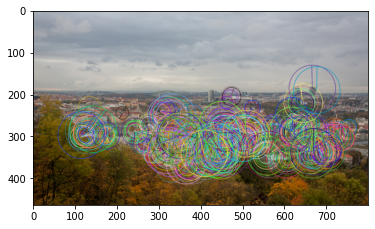

In [ ]:
img = cv2.cvtColor(cv2.imread('data/strahov.png'), cv2.COLOR_BGR2RGB)

det = cv2.ORB_create(500)
kps, descs = det.detectAndCompute(img, None)

out_img = cv2.drawKeypoints(img, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(out_img)

In [ ]:
img = cv2.cvtColor(cv2.imread('data/strahov.png'), cv2.COLOR_BGR2RGB)

det = cv2.ORB_create(500)
kps, descs = det.detectAndCompute(img, None)
lafs, r = laf_from_opencv_kpts(kps, 1.0, with_resp=True)

<matplotlib.image.AxesImage>

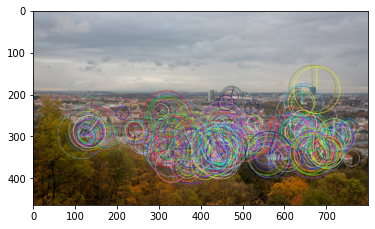

In [ ]:

img = cv2.cvtColor(cv2.imread('data/strahov.png'), cv2.COLOR_BGR2RGB)

det = cv2.ORB_create(500)
kps, descs = det.detectAndCompute(img, None)
lafs, r = laf_from_opencv_kpts(kps, 1.0, with_resp=True)
kps_back = opencv_kpts_from_laf(lafs, 1.0, r)
out_img = cv2.drawKeypoints(img, kps_back, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(out_img)

OpenCV uses different conventions for the local feature scale. 

E.g. to get equivalent kornia LAF from ORB keypoints, one should you mrSize = 0.5, 
while for SIFT -- 6.0. The orientation convention is also different for kornia and OpenCV.

In [ ]:
#| export 
def laf_from_opencv_ORB_kpts(kpts: List[cv2.KeyPoint], 
                             device: torch.device=torch.device('cpu'),
                             with_resp: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    return laf_from_opencv_kpts(kpts, 1.0, device, with_resp)

def laf_from_opencv_SIFT_kpts(kpts: List[cv2.KeyPoint], 
                              device: torch.device=torch.device('cpu'),
                              with_resp: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    return laf_from_opencv_kpts(kpts, 6.0, device, with_resp)


def opencv_SIFT_kpts_from_laf(lafs, resps: Optional[torch.Tensor] = None):
    return opencv_kpts_from_laf(lafs, 6.0, resps);

def opencv_ORB_kpts_from_laf(lafs, resps: Optional[torch.Tensor] = None):
    return opencv_kpts_from_laf(lafs, 1.0, resps);

libpng warning: iCCP: known incorrect sRGB profile


<matplotlib.image.AxesImage>

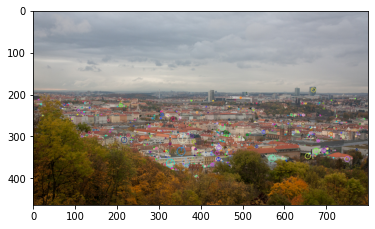

In [ ]:

img = cv2.cvtColor(cv2.imread('data/strahov.png'), cv2.COLOR_BGR2RGB)

det = cv2.SIFT_create(500)
kps, descs = det.detectAndCompute(img, None)

out_img = cv2.drawKeypoints(img, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(out_img)

The keypoints are small, because, unlike for ORB, for SIFT OpenCV draws not real regions to be described, but the radius of the blobs, which are detected. Kornia and kornia_moons, inlike OpenCV, shows the real description region.

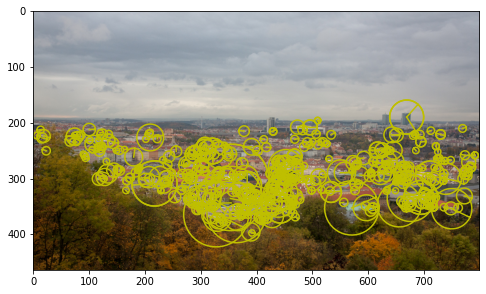

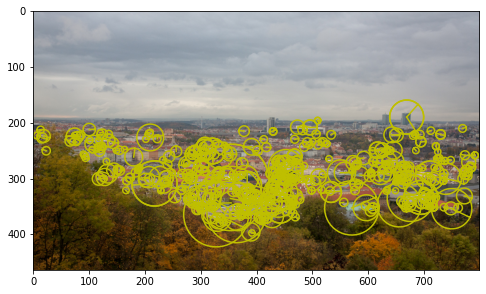

In [ ]:
lafs, r = laf_from_opencv_SIFT_kpts(kps, with_resp=True)
visualize_LAF(image_to_tensor(img, False), lafs, 0, 'y', figsize=(8,6))

If you want to see the image, similar to OpenCV one, you can scale LAFs by factor 1/12.

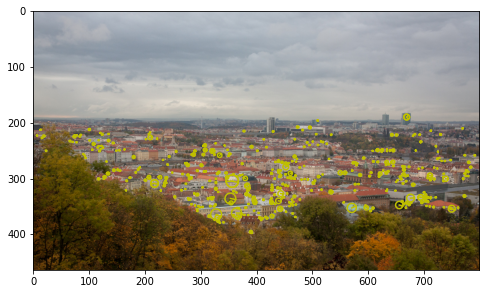

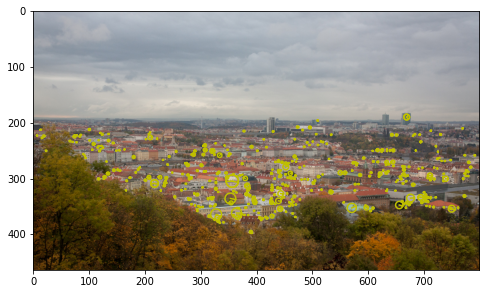

In [ ]:
visualize_LAF(image_to_tensor(img, False),
              kornia.feature.laf.scale_laf(lafs, 1./6.0), 0, 'y', figsize=(8,6))

Now let's do the same for matches format

In [ ]:
#| export
def cv2_matches_from_kornia(match_dists: torch.Tensor, match_idxs: torch.Tensor) -> List[cv2.DMatch]:
    return [cv2.DMatch(idx[0].item(), idx[1].item(), d.item()) for idx, d in zip (match_idxs, match_dists)]

def kornia_matches_from_cv2(cv2_matches, device=torch.device('cpu')):
    num_matches = len(cv2_matches)
    match_dists = torch.zeros(num_matches, 1, device=device, dtype=torch.float)
    match_idxs = torch.zeros(num_matches, 2, device=device, dtype=torch.long)
    for i, m in enumerate(cv2_matches):
        match_dists[i, 0] = m.distance
        match_idxs[i, 0] = m.queryIdx
        match_idxs[i, 1] = m.trainIdx
    return match_dists, match_idxs

libpng warning: iCCP: known incorrect sRGB profile


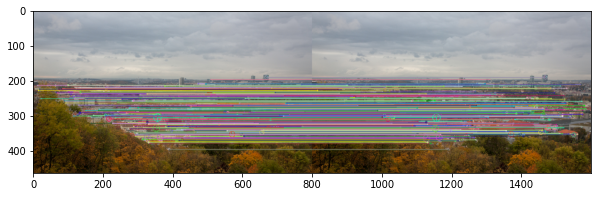

In [ ]:
img = cv2.cvtColor(cv2.imread('data/strahov.png'), cv2.COLOR_BGR2RGB)

det = cv2.SIFT_create(500)
kps, descs = det.detectAndCompute(img, None)
                                  
match_dists, match_idxs = kornia.feature.match_nn(torch.from_numpy(descs).float(),
                                             torch.from_numpy(descs).float())

cv2_matches = cv2_matches_from_kornia(match_dists, match_idxs)
out_img = cv2.drawMatches(img, kps, img, kps, cv2_matches, None,
                          flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(10,5))
plt.imshow(out_img)

match_dists_back, match_idxs_back = kornia_matches_from_cv2(cv2_matches)

assert(allclose(match_dists_back, match_dists))
assert(allclose(match_idxs_back, match_idxs))

In [ ]:
#| export

def make_keypoints_upright(kpts):
    unique_kp = []
    for i, kk in enumerate(kpts):
        if i > 0:
            if kk.response == kpts[i - 1].response:
                continue
        kk.angle = 0
        unique_kp.append(kk)
    top_resps = np.array([kk.response for kk in unique_kp])
    idxs = np.argsort(top_resps)[::-1]
    return [unique_kp[i] for i in idxs]
            

class OpenCVDetectorKornia(nn.Module):
    def __init__(self, opencv_detector, mrSize: float = 6.0, make_upright = False, max_kpts = -1):
        super().__init__()
        self.features = opencv_detector
        self.mrSize = mrSize
        self.make_upright = make_upright
        self.max_kpts = max_kpts
        
    def forward(self, x:torch.Tensor, mask=None):
        max_val = x.max()
        if max_val < 2.0:
            img_np = (255 * kornia.tensor_to_image(x)).astype(np.uint8)
        else:
            img_np =  kornia.tensor_to_image(x).astype(np.uint8)
        if mask is not None:
            mask = kornia.tensor_to_image(x).astype(np.uint8)
        kpts = self.features.detect(img_np, mask)
        # Compute descriptors
        if self.make_upright:
            kpts = make_keypoints_upright(kpts)
            kpts = kpts[:min(len(kpts), self.max_kpts)]
        lafs, resp = laf_from_opencv_kpts(kpts, mrSize=self.mrSize, with_resp=True, device=x.device)
        return lafs, resp

    
class OpenCVFeatureKornia(nn.Module):
    def __init__(self, opencv_detector, mrSize: float = 6.0):
        super().__init__()
        self.features = opencv_detector
        self.mrSize = mrSize
        
    def forward(self, x:torch.Tensor, mask=None):
        max_val = x.max()
        if max_val < 2.0:
            img_np = (255 * kornia.tensor_to_image(x)).astype(np.uint8)
        else:
            img_np =  kornia.tensor_to_image(x).astype(np.uint8)
        if mask is not None:
            mask = kornia.tensor_to_image(x).astype(np.uint8)
        kpts, descs = self.features.detectAndCompute(img_np, mask)
        lafs, resp = laf_from_opencv_kpts(kpts, mrSize=self.mrSize, with_resp=True, device=x.device)
        return lafs, resp, torch.from_numpy(descs).to(device=x.device)[None]


class OpenCVDetectorWithAffNetKornia(nn.Module):
    def __init__(self, opencv_detector, make_upright = False, mrSize: float = 6.0, max_kpts = -1):
        super().__init__()
        self.features = opencv_detector
        self.mrSize = mrSize
        self.affnet = kornia.feature.LAFAffNetShapeEstimator(True).eval()
        self.make_upright = make_upright
        self.max_kpts = max_kpts
        
    def forward(self, x:torch.Tensor, mask=None):
        self.affnet = self.affnet.to(x.device)
        max_val = x.max()
        if max_val < 2.0:
            img_np = (255 * kornia.tensor_to_image(x)).astype(np.uint8)
        else:
            img_np =  kornia.tensor_to_image(x).astype(np.uint8)
        if mask is not None:
            mask = K.tensor_to_image(x).astype(np.uint8)
        kpts = self.features.detect(img_np, mask)
        # Compute descriptors
        if self.make_upright:
            kpts = make_keypoints_upright(kpts)
            kpts = kpts[:min(len(kpts), self.max_kpts)]
        lafs, resp = laf_from_opencv_kpts(kpts, mrSize=self.mrSize, with_resp=True, device=x.device)
        ori = kornia.feature.get_laf_orientation(lafs)
        lafs = self.affnet(lafs, x.mean(dim=1, keepdim=True))
        lafs = kornia.feature.set_laf_orientation(lafs, ori)
        return lafs, resp

libpng warning: iCCP: known incorrect sRGB profile


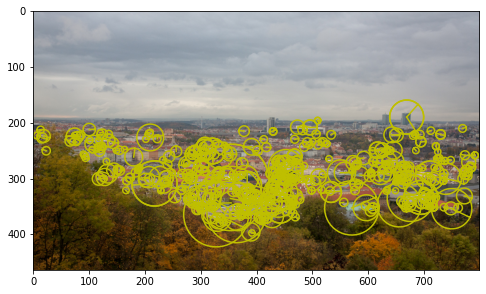

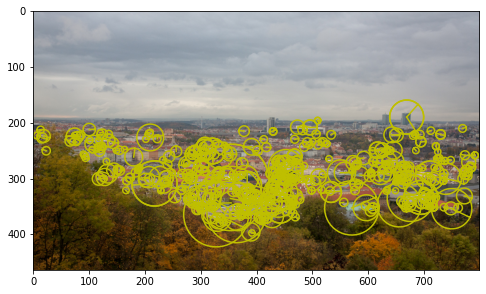

In [ ]:
kornia_cv2dog = OpenCVDetectorKornia(cv2.SIFT_create(500))
kornia_cv2sift = OpenCVFeatureKornia(cv2.SIFT_create(500))


timg = image_to_tensor(cv2.cvtColor(cv2.imread('data/strahov.png'), cv2.COLOR_BGR2RGB), False).float()/255.


lafs, r = kornia_cv2dog(timg)
lafs2, r2, descs2 = kornia_cv2sift(timg)


visualize_LAF(timg, lafs, 0, 'y', figsize=(8,6))

/var/folders/j9/y_61c9h10xz3d5g4d1rrny5c0000gn/T/ipykernel_19919/2708263890.py:65: DeprecationWarning: `LAFAffNetShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
  self.affnet = kornia.feature.LAFAffNetShapeEstimator(True).eval()
libpng warning: iCCP: known incorrect sRGB profile


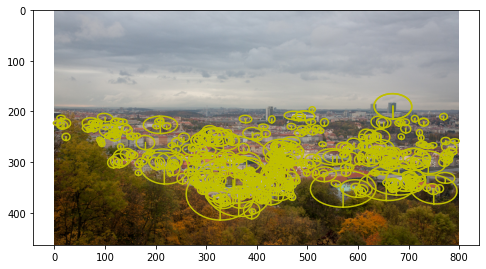

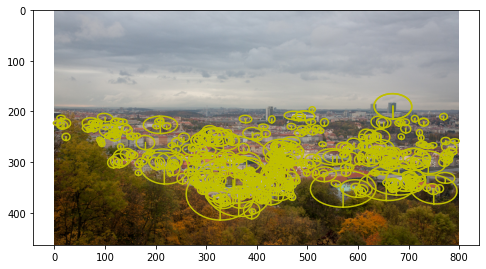

In [ ]:

kornia_cv2dogaffnet = OpenCVDetectorWithAffNetKornia(cv2.SIFT_create(500), make_upright=True)


timg = image_to_tensor(cv2.cvtColor(cv2.imread('data/strahov.png'), cv2.COLOR_BGR2RGB), False).float()/255.


lafs, r = kornia_cv2dogaffnet(timg)


visualize_LAF(timg, lafs, 0, 'y', figsize=(8,6))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()